# Why Expose A Model As API?

R is widely used for data science and deploying models into production. The end users are typically IT and enterprise software that need to consume solutions that can be easily integrated with their software.

You can replicate the code into other programming languages used widely around the world by software developers but here lies the problem - Majority of the programming languages do not have libraries to perform ML!!!

So one good solution is to expose the model as API. The most common type of API is REST/RESTful API. REST APIs allow two applications to talk to each other over the Internet using HTTP as their protocol. In simpler terms, they deliver the requests from the client to the server (specified in the URL) and then deliver the responses (as requested in the method - GET, PUT, POST) back to the client.

By exposing the R Model as API, we can let other applications to use model for the purposes it is designed for without having to worry about the underlying environment/architecture.

# Using Rest APIs to Expose Model as a Service

Do we have a package in R to help us with this? The answer is yes. Which one? The answer is **"Plumber"**

Plumber is straightforward and easy to use. It is an open source package that lets you create APIs by decorating the R functions with special annotations/comments. Comments can be prefixed with "#'" or "#*". 
"#'" is recommended.

To read more, refer **[rplumber](https://www.rplumber.io/)**


To start using it, type :

In [1]:
library("plumber")

Before we can start using Plumber to create APIs, we need a trained ML model.
Let's begin with training a simple model for the **[Classic Titanic problem from Kaggle](https://www.kaggle.com/c/titanic/data)** which predicts the Survival on the Titanic.

In [3]:
#Read the dataset
titanic_data <- read.csv("dataset/train.csv")

#View the data types of variables
str(titanic_data)

#Preprocess the data, i.e clean the NA/missing values, convert all variables to factor 
#variables and include only the significant variables in the model.
changeTitanicData <- function(input_titantic_data) {
  cleaned_titanic_data <- data.frame(
    Survived = factor(input_titantic_data$Survived, levels = c(0, 1)),  
    Sex = factor(input_titantic_data$Sex, levels = c("male", "female")),
    Pclass = factor(input_titantic_data$Pclass, levels = c("1", "2", "3")),
    Age = factor(dplyr::if_else(input_titantic_data$Age < 18, "child", "adult", "NA"), 
                  levels = c("child", "adult", "NA"))
    )
}

processed_titanic_data <- changeTitanicData(titanic_data) 


'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [4]:
#Split the data into 2 sets - train and test
split_set <- sample(1:nrow(processed_titanic_data), size = floor(0.7*nrow(processed_titanic_data)))
train_set <- processed_titanic_data[split_set, ]
test_set <- processed_titanic_data[-split_set, ]

In [5]:
#Train the model using RandomForest algorithm
#Install 'RandomForest' package. Only for the first time 
#install.packages('randomForest')
library(randomForest)

set.seed(415)
titanic_rf <- randomForest(Survived ~ Sex + Pclass + Age, data = train_set, importance = TRUE, na.action = NULL)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 162  43
         1   6  57
                                          
               Accuracy : 0.8172          
                 95% CI : (0.7656, 0.8616)
    No Information Rate : 0.6269          
    P-Value [Acc > NIR] : 9.218e-12       
                                          
                  Kappa : 0.5775          
 Mcnemar's Test P-Value : 2.706e-07       
                                          
            Sensitivity : 0.9643          
            Specificity : 0.5700          
         Pos Pred Value : 0.7902          
         Neg Pred Value : 0.9048          
             Prevalence : 0.6269          
         Detection Rate : 0.6045          
   Detection Prevalence : 0.7649          
      Balanced Accuracy : 0.7671          
                                          
       'Positive' Class : 0               
                                          

              Reference
Prediction     Not Survived Survived
  Not Survived          162       43
  Survived                6       57

[1] "Accuracy: 81.72%"


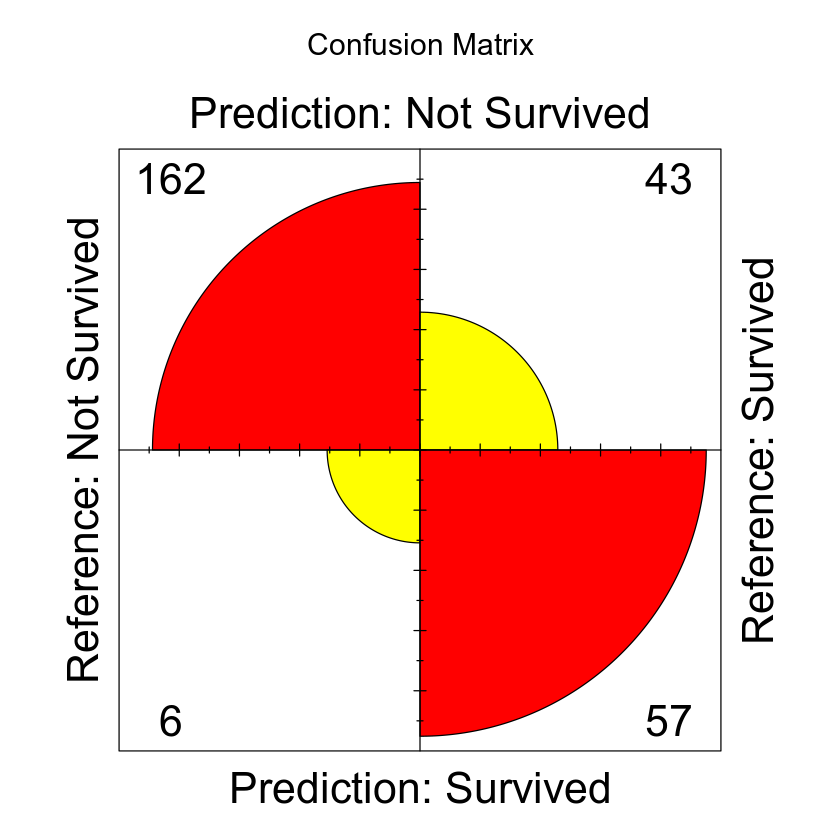

In [9]:
#Evaluate the model
test_predict_titanic <- predict(titanic_rf, newdata = test_set, type = "response") 

library(caret)
#Plot Confusion Matrix
confusionMatrix(test_predict_titanic, test_set$Survived)

lvs <- c("Survived", "Not Survived")
truth <- factor(rep(lvs, times = c(100,168)), levels = rev(lvs))
pred <- factor(c(rep(lvs, times = c(57,43)), rep(lvs, times = c(6, 162))), levels = rev(lvs))
xtab <- table(pred, truth)
cm <- confusionMatrix(pred, truth)
cm$table
fourfoldplot(cm$table, color = c("yellow", "red"), conf.level = 0, margin = 1, main = "Confusion Matrix")
#Model Accuracy
msg <- paste0("Accuracy: ", round(100 * sum(diag(cm$table))/sum(cm$table), 2), "%")
print(msg)

In [10]:
#Save the model, can be loaded into a variable
saveRDS(titanic_rf, file = "random_forest_titanic_model.Rds", compress = TRUE)

# Creating Plumber APIs

Plumber uses two files:
1. A file containing the API endpoint definitions, i.e the functions/model that you want to expose.
2. A server file also called router, i.e one that reads these definitions and spins up a web server to process the request.

**How does Plumber work?**
Plumber has two distinct functions to process the incoming HTTP request:
1. **Endpoints-** 
    It can be viewed as a process encapsulating the logic responsible for generating the response.

2. **Filters-**
    It can be viewed as a pipeline for handling the incoming request. It can do the following 3 things as part of     request handling:
    (a)Forward the request to next filter or endpoint.
    (b)Throw an error
    (c)Return the response by itself, not forward

When a HTTP request is received, Plumber passes the request to all the defined filters. Once the request has processed/handled by the filters, Plumber router looks for an endpoint that can satisfy the request. If it finds one, that endpoint is invoked and the value returned by the endpoint is returned as the response. If no endpoint is available to process the request, the standard HTTP error 404 is returned. To read more, refer **[Routing and Input](https://www.rplumber.io/docs/routing-and-input.html)**.
    
Let's start by creating the API file (titanic_API.R). This file includes special annotations as mentioned earlier. The functions defined below it are exposed as API. 

In [ ]:
#titanic_API.R

library("plumber")
titanic_model <- readRDS("random_forest_titanic_model.Rds")

#' Landing Page with a description
#' @get /welcome
#' @html
function(){
  "<html>
    <h1><center>
    <b>Predicting Survival on Titanic dataset using Random Forest</b></center>
    </h1>

    <body>
      </br>
      <p>This model predicts the Survival probability of the passengers on Titanic given the 
        Age (in years), Sex (male/female) and Pclass (ticket class).</p>
      <p>It also outputs the model accuracy.</p>
      </br></br>
      <p>Provide the the following inputs :</p>
      <p>Sex = male/female</p>
      <p>Pclass = 1/2/3</p>
      <p>Age = number between 0 to 100 or NA if Age is unknown</p>
      </br></br>
      <p>What can you expect?</p>
      <p>Survival Probability, a value <b>0</b> (not survived) or <b>1</b> (survived)</p>
      <p>Model Accuracy in %</p>
    </body>

  </html>"
}

#Transforming the input parameters
transformTitanicData <- function(input_titantic_data) {
    cleaned_titanic_data <- data.frame(
    Sex = factor(input_titantic_data$Sex, levels = c("male", "female")),
    Pclass = factor(input_titantic_data$Pclass, levels = c("1", "2", "3")),
    Age = factor(dplyr::if_else(input_titantic_data$Age < 18, "child", "adult", "NA"), 
                 levels = c("child", "adult", "NA"))
  )
}

#Validating the input
validate_input <- function(Sex, Pclass, Age)
{
  Sex = (Sex %in% c("male", "female"))
  Pclass = (Pclass %in% c(1,2,3))
  Age = (Age >= 0 && Age <= 100 | is.na(Age))
  if(all(c(Sex, Pclass, Age)))
  {
    return("OK")
  }
  else
  {
    errorStat <- "Sex must be either male or female,
                  Pclass must be either 1,2 or 3,
                  Age must be a number between 0 to 100 or NA"
    return(errorStat)
  }
}

library(jsonlite)
#' Pass the input parameters. Validate the inputs
#' @param Sex = "male/female"
#' @param Pclas = "1/2/3"
#' @param Age = "number between 0 and 100 or NA"
#' @get /survival
predict_survival <- function(Sex = NULL, Pclass = NULL, Age = NA) {
  age = as.integer(Age)
  pclass = as.integer(Pclass)
  sex = tolower(Sex)
  valid_input <- validate_input(sex, pclass, age)
  if (valid_input[1] == "OK") 
  {
    data <- data.frame(Age=age, Pclass=pclass, Sex=sex)
    clean_data <- transformTitanicData(data)
    prediction <- predict(titanic_model, clean_data, type = "response")
    result <- list(
      input = list(data),
      output = list("Survival Probability" = unbox(prediction),
                      "Model Accuracy" = print(msg)),
      status = 200
      )
  } 
  else 
  {
      result <- list(
      input = list(Age = Age, Pclass = Pclass, Sex = Sex), 
      output = list(input_error = valid_input), 
      status = 400 
      )
  }
  return(result)
}

#' Plot Conusion Matrix
#' @get /plot
#' @png
function()
{
  library(caret)
  cm <- confusionMatrix(test_predict_titanic, test_set$Survived)
  lvs <- c("Survived", "Not Survived")
  truth <- factor(rep(lvs, times = c(109,159)), levels = rev(lvs))
  pred <- factor(c(rep(lvs, times = c(52, 57)), rep(lvs, times = c(9, 150))), levels = rev(lvs))
  xtab <- table(pred, truth)
  cm <- confusionMatrix(pred, truth)
  cm$table
  fourfoldplot(cm$table, color = c("yellow", "red"), conf.level = 0, margin = 1, main = "Confusion Matrix")
}
  

Let's create the second file (router.R). This file reads the API definitions, routes the request to the endpoint and starts the webserver on the specified port.

In [ ]:
#router.R

#Runs the webserver on http://localhost:8000/
library(plumber)
API_model <- plumb("titanic_API.R")
API_model$run(port = 8000)

You should be seeing this on your output console:

**Starting server to listen on port 8000**

**Running the swagger UI at http://127.0.0.1:8000/__swagger__/**

# Validating the API results

1. Typing the URL in the **Web browser**:

     - You can access the landing page by typing the following URL:
    > **http://localhost:8000/welcome** 
    
    > ![API Landing Screen](Images/API_Landing_Page.png)

     - You can view the Survival Probability and Model Accuracy by typing the following URL:
    > You will have to pass the input parameters as query string.
    
    > (a)For valid input - **http://localhost:8000/survival?Sex=female&Pclass=2&Age=50**
    
    > ![API Survival Page with valid inputs](Images/API_Survival_Page_Web.png)
    
    > (b)For invalid input - **http://localhost:8000/survival?Sex=female&Pclass=4&Age=50**
    
    > ![API Survival Page with invalid inputs](Images/API_Survival_invalidInputs_Web.png)
    
     - You can view the Confusion Matrix by typing the following URL:
     > **http://localhost:8000/plot**
     
     >![Confusion Matrix](Images/Confusion-Matrix.png)
     

2. Use the **curl** command:

     - Open the command prompt and enter the following command to view the landing page:
    > **curl -X GET http://localhost:8000/welcome**
   
     - Open the command prompt and enter the following command to obtain the Survival Probability and Model   Accuracy: 
    > (a)For valid input - **curl -X GET http://localhost:8000/survival -d '{"Sex":"female", "Pclass": 2, "Age": 25}'** 
    
    > ![API Survival Page with invalid inputs](Images/API_Survival_validInputs_cmd.png)
    
    > (b)For invalid input - **curl -X GET http://localhost:8000/survival -d '{"Sex":"male", "Pclass": 3, "Age": 150}'**
    
    > ![API Survival Page with invalid inputs](Images/API_Survival_invalidInputs_cmd.png)
    
    
3. Using a client such as **POSTMAN**:
    
    > Check the **[Download](https://www.getpostman.com/downloads/)** and 
    **[Installation](https://learning.getpostman.com/docs/postman/launching_postman/installation_and_updates/)** pages for getting started with POSTMAN.
    > Once you have successfully installed and launched the POSTMAN app, enter the urls as necessary to fetch the       corresponding responses.
        
    > ![API Survival Page with valid inputs](Images/API_Survival_validInputs_Postman.png)
    
    > ![API Survival Page with invalid inputs](Images/API_Survival_invalidInputs_Postman.png)

# Summing it up with a Flow Diagram

We have successfully built a model, exposed our model as an API and validated the API test!

Let me sum up the entire process in a **flow diagram**

![Entire Process Flow](Images/Process-Flow.png)

# Closing Remarks

We have seen the ease of using Plumber to create web APIs and expose our R functions as APIs with a simple example. 
For more information on Plumber package read up the **[Plumber Documentation](https://www.rplumber.io)**.

Here are a few other packages in R that help in exposing R models through API development:

**1. [DeployR](https://docs.microsoft.com/en-us/machine-learning-server/deployr/deployr-about)** - It is Microsoft's integration platform for R analytics inside web, mobile, desktop, dashboard as well as backend applications.

**2. [OpenCPU](https://www.opencpu.org/)** - Provides reliable and interoperable HTTP APIs for data analysis based on R. One of the likely one to choose for production.

**3. [Shiny](http://shiny.rstudio.com/)** - It is an R package that helps build interactive web applications from R.

**4. [rApache](https://www.r-bloggers.com/exposing-r-script-as-api/)** - It is a project supporting web application development using the R.  